# А/B тест пользователей мобильного приложения (интерпретация результатов)

<font color="DarkCyan"> Что тут есть: проверка и обработка выборок A/B тестирования, EDA, воронки, функция z-теста по всем уровням воронки

**Вводная:** заказчик провел А/В тестирование согласно собственному техническому заданию и запросил интерпретировать результаты теста
<br>**Заказчик / платформа:** мобильное приложение с возможностью совершения покупок
<br>**Задача:** EDA, проверка корректности выборки для А/В теста и интерпретация результатов А/В теста
<br>**Описание источников данных от заказчика:**
>- *ab_project_marketing_events.csv* - календарь маркетинговых событий на 2020 год
>- *final_ab_new_users.csv* - все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года
>- *final_ab_events.csv* - все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года
>- *final_ab_participants.csv* - таблица участников тестов

**Техническое задание от заказчика:**
<br>**Название теста:** recommender_system_test
<br>**Группы:** А (контрольная), B (новая платёжная воронка)
<br>**Дата запуска:** 2020-12-07
<br>**Дата остановки набора новых пользователей:** 2020-12-21
<br>**Дата остановки:** 2021-01-04
<br>**Аудитория:** 15% новых пользователей из региона EU
<br>**Назначение теста:** тестирование изменений, связанных с внедрением улучшенной рекомендательной системы
<br>**Ожидаемое количество участников теста:** 6000
<br>**Ожидаемый эффект:** за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
>- конверсии в просмотр карточек товаров — событие product_page
>- просмотры корзины — product_cart
>- покупки — purchase

## Предобработка данных

### Старт работ

>- подгрузим библиотеки для работы
>- объявим переменные с датасетами заказчика
>- циклом посмотрим краткую инфу о датасете

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from plotly import graph_objects as go 
#import plotly.express as px
import math as mth
#import statistics as stat
import numpy as np
from scipy import stats as st

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
ev_20 = pd.read_csv('ab_project_marketing_events.csv') # календарь маркетинговых событий на 2020 год;
users = pd.read_csv('final_ab_new_users.csv') # все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;
events = pd.read_csv('final_ab_events.csv') #  все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;
partis = pd.read_csv('final_ab_participants.csv') #  таблица участников тестов.

In [4]:
for _ in [ev_20, users, events, partis]:
    _.info()
    display(_.head(1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test


**Увидели кол-во строк - во всех датасетах нет пропусков, кроме сета с событиями - в поле details заполняются не все данные, так как там находится цена покупки (по всей видимости, приходит не вся информация). Это поле некритично для нас, тк цена покупки не участвует в исследовании**

In [5]:
temp_0001 = events.groupby('event_name', as_index=False).agg({'details': 'sum'})
temp_0001['details'] = temp_0001['details'].astype(int)
temp_0001

,event_name,details
0,login,0
1,product_cart,0
2,product_page,0
3,purchase,1498082


### Дубликаты и формат полей

>- проверим наличие строк дубликатов в датасетах (просуммируем строки-дубли, если дублей нет - получим 0)
>- предобработаем формат дат и создадим столбец без времени в сете events
>- посмотрим кол-во уникальных пользователей "на заре" анализа

In [6]:
for _ in [ev_20, users, events, partis]:
    print(_.duplicated().sum())

0
0
0
0


In [7]:
ev_20['start_dt'] = pd.to_datetime(ev_20['start_dt'])
ev_20['finish_dt'] = pd.to_datetime(ev_20['finish_dt'])
users['first_date'] = pd.to_datetime(users['first_date'])
users = users.rename(columns={'first_date': 'first_dt'})
events['event_dt'] = pd.to_datetime(events['event_dt'])
events['dt'] = events['event_dt'].dt.date
events['dt'] = pd.to_datetime(events['dt'])

In [8]:
users['user_id'].nunique()

61733

**Все ок - убедились в отсутствии дублей, поменяли формат на datetime там, где это было нужно. Увидели, что в исходном сете с регистрациями около 62 тысяч уникальных пользователей. Переходим к проверке выборки для теста.**

## Проверка выборки теста

### Фильтр по дате

>- создадим функцию для оперативной группировки датасета
>- проверим данные: в сете events должен быть период с 7 декабря 2020 по 4 января 2021
>- проверим данные: в сете users (регистрации) должен быть период с 7 по 21 декабря 2020
>- обрежем датасеты при необходимости. Проверим, сколько осталось юзеров

#### функция группировки

In [9]:
def group_me(data, level=[], agglevel='', aggfunc=''):
    union = (data.groupby(level, as_index=False)
             .agg({agglevel: aggfunc})
             .rename(columns={agglevel: aggfunc})
             .reset_index(drop=True)
             .sort_values(by=aggfunc, ascending=False))
    return union

In [10]:
display(events['event_dt'].min(), events['event_dt'].max())

Timestamp('2020-12-07 00:00:33')

Timestamp('2020-12-30 23:36:33')

In [11]:
display(users['first_dt'].min(), users['first_dt'].max())

Timestamp('2020-12-07 00:00:00')

Timestamp('2020-12-23 00:00:00')

In [12]:
users = users.query('first_dt <= "2020-12-21"')

In [13]:
users['user_id'].nunique()

56470

**Обрезали сет с регистрациями до периода, указанного в техническом задании (7-21 декабря 2020). Осталось ~56.5 тысяч юзеров. Сет с событиями в фильтрации не нуждался, период в нем меньше заданного (до 4 января 2021) - вместе с тем продолжим работать с теми данными, что у нас есть.**

### фильтр по региону

>- отфильтруем сет с пользователями по региону, оставив только заданный в тех.задании (EU). Посмотрим, сколько юзеров осталось
>- рассчитаем долю 15% (заказчик указал, что 15% новых зарегистрированных из EU в заданный период должны попасть в тест)

In [14]:
users = users.query('region == "EU"')
unit = users['user_id'].nunique()
unit

42340

In [15]:
print(unit * 0.15)

6351.0


**Осталось 42 тысячи пользователей + 6351 человек это желаемые 15% из их числа.**

### соединение пользователей с событиями

>- создадим список уникальных юзеров из EU (отфильтрованных по дате регистрации)
>- отфильтруем датасет с событиями только по этим id. Посмотрим инфо о датасете
>- присоединим таблицу пользователей к таблице событий, чтобы в объединенном сете появилась дата регистрации юзера
>- создадим в новом сете колонку diff, рассчитывающую разницу между датой регистрацией и событием. По тех.заданию разница должна составлять не более 14 дней
>- посмотрим инфо о новом объединенном датасете

In [16]:
users_eu = list(users['user_id'].unique())

In [17]:
events = events.query('user_id in @users_eu')
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302653 entries, 1 to 440316
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     302653 non-null  object        
 1   event_dt    302653 non-null  datetime64[ns]
 2   event_name  302653 non-null  object        
 3   details     44918 non-null   float64       
 4   dt          302653 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 13.9+ MB


In [18]:
union = events.merge(users, on='user_id', how='left')
union['diff'] = (union['dt'] - union['first_dt']).dt.days

In [19]:
union = union.query('diff <= 14')
union.tail(1)

,user_id,event_dt,event_name,details,dt,first_dt,region,device,diff
302623,2C29721DDDA76B2A,2020-12-29 05:58:20,login,NaN,2020-12-29,2020-12-20,EU,iPhone,9


In [20]:
union.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291160 entries, 0 to 302623
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     291160 non-null  object        
 1   event_dt    291160 non-null  datetime64[ns]
 2   event_name  291160 non-null  object        
 3   details     43227 non-null   float64       
 4   dt          291160 non-null  datetime64[ns]
 5   first_dt    291160 non-null  datetime64[ns]
 6   region      291160 non-null  object        
 7   device      291160 non-null  object        
 8   diff        291160 non-null  int64         
dtypes: datetime64[ns](3), float64(1), int64(1), object(4)
memory usage: 22.2+ MB


**C учетом фильтра по пользователям из EU + фильтра по разнице в днях потеряли около 11 тысяч строк с событиями.**

>- посмотрим сколько имеем событий тотал в разрезе типа

In [21]:
temp_0 = group_me(union, level='event_name', agglevel='user_id', aggfunc='count')
temp_0.reset_index(drop=True)

,event_name,count
0,login,124584
1,product_page,82204
2,purchase,43227
3,product_cart,41145


**Вырисовывается воронка - но интересная: больше всего логинов, далее переходы на продуктовую страницу - после по кол-ву лидируют покупки и только потом продуктовая корзина. Вероятно, в приложении можно переходить на этап покупки напрямую. Подробнее с воронками разберемся на следующих этапах.**

### пересечение с маркетинговыми кампаниями

>- заказчик предоставил сет с рекламныии кампаниями, проходящими в 2020 году. Посмотрим, что за кампании проходили одновременно с тестом
>- создадим функцию для форматирования дат для красивого отображения в графиках
>- создадим новый стобец в датасете (с короткой датой) 
>- сделаем временный сет с кол-вом событий по дням
>- и временный сет с кол-вом регистраций пользователей по дням
>- посмотрим графики. Сделаем выводы

In [22]:
ev_20 = (ev_20.sort_values(by='start_dt')
         .reset_index(drop=True).query('start_dt >= "2020-12-01" & regions != "CIS"'))
ev_20

,name,regions,start_dt,finish_dt
12,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


#### функция форматирования дат

In [23]:
def format_date(date):
    return date.strftime("%m-%d")

In [24]:
union['beauty_dt'] = union['dt'].apply(format_date)

In [25]:
# здесь считаем количество событий, не уникальных
temp_01 = group_me(union, level='beauty_dt', agglevel='user_id', aggfunc='count')
temp_01 = temp_01.sort_values(by='beauty_dt')

##### график

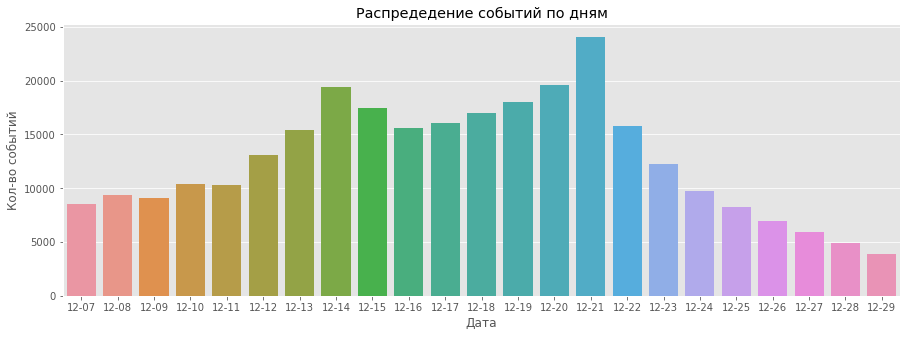

In [26]:
plt.figure(figsize=(15,5))
plt.style.use('ggplot')
sns.barplot(x=temp_01['beauty_dt'], y=temp_01['count']);
plt.title('Распредедение событий по дням')
plt.xlabel('Дата');
plt.ylabel('Кол-во событий');

In [27]:
temp_02 = group_me(union, level='first_dt', agglevel='user_id', aggfunc='nunique')
temp_02['beauty_dt'] = temp_02['first_dt'].apply(format_date)
temp_02 = temp_02.sort_values(by='first_dt')

##### график

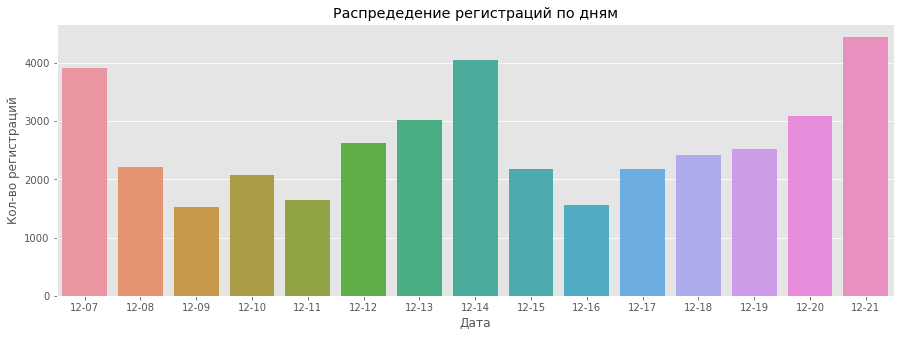

In [28]:
plt.figure(figsize=(15,5))
plt.style.use('ggplot')
sns.barplot(x=temp_02['beauty_dt'], y=temp_02['nunique']);
plt.title('Распредедение регистраций по дням')
plt.xlabel('Дата');
plt.ylabel('Кол-во регистраций');

**Старт единственной кампании, которая пересекается с тестом, был 25 декабря. По графику событий не видим пиков в эти даты (плавный спад с 22 декабря). График с регистрациями составили справочно (кампания начинается позже периода набора новых юзеров). В обоих визуализациях видим подъем к дате 21/12/20. По кол-ву событий видим затихание к концу года (что характерно для сезонности перед НГ).
<br>Итого считаем, что кампания не оказала существенного влияния на поведение юзеров. Можем переходить к проверки выборок.** 

### пересечение несколько групп АБ-тестирования

>- посмотрим кол-во уникальных пользователей в сете
>- посмотрим то же самое в группировке по группам и видам теста
>- отфильтруем сет по пользователям из ЕС / с нужным периодом регистрации (базовая отсечка согласно тех.заданию). Посмотрим, сколько уникальных осталось

In [29]:
eq = partis['user_id'].nunique()
eq

16666

In [30]:
temp_03 = group_me(partis, level=['ab_test', 'group'], agglevel='user_id', aggfunc='nunique')
temp_03

,ab_test,group,nunique
0,interface_eu_test,A,5831
1,interface_eu_test,B,5736
2,recommender_system_test,A,3824
3,recommender_system_test,B,2877


In [31]:
partis = partis.query('user_id in @users_eu')
eq_2 = partis['user_id'].nunique()
print(eq_2, '|', eq - eq_2)

15314 | 1352


**На этом этапе отсеяли 1352 юзера.**
>- сформируем лист юзеров, попавших в тестовую группу "В" в стороннем тестировании. **Их мы удаляем из всех групп без исключения. Что касается группы "А" стороннего теста - ее можно оставить во всех группах, так как на нее не оказывалось никакого влияния**
>- удалим юзеров из группы В стороннего теста
>- посмотрим, сколько юзеров осталось

In [32]:
b_group_users = list(partis.query('group == "B" & ab_test == "interface_eu_test"')['user_id'].unique())

In [33]:
partis = partis.query('user_id not in @b_group_users')

In [34]:
temp_03 = group_me(partis, level=['ab_test', 'group'], agglevel='user_id', aggfunc='nunique')
temp_03

,ab_test,group,nunique
0,interface_eu_test,A,5342
1,recommender_system_test,A,3195
2,recommender_system_test,B,2373


In [35]:
eq_3 = partis['user_id'].nunique()
print(eq_3, '|', eq_2 - eq_3, '|', eq - eq_3)

10091 | 5223 | 6575


**На этом этапе отсеяли 5223 юзера (и 6575 от общего кол-ва датасета). Из групп пользователи ушли равномерно.**
>- удалим оставшихся юзеров стороннего теста из датасета
>- посмотрим, сколько осталось в группах
>- и сколько осталось тотал

In [36]:
partis = partis.query('ab_test != "interface_eu_test"')

In [37]:
temp_05 = group_me(partis, level=['ab_test', 'group'], agglevel='user_id', aggfunc='nunique')
temp_05

,ab_test,group,nunique
0,recommender_system_test,A,3195
1,recommender_system_test,B,2373


In [38]:
eq_4 = partis['user_id'].nunique()
print(eq_4, '|', eq_3 - eq_4, '|', eq_2 - eq_4, '|', eq - eq_4)

5568 | 4523 | 9746 | 11098


**Итого осталась тестовая группа в размерез 5568 юзеров. Фильтрами / отсечками убрали 11098 юзеров (разница с исходным датасетом).**
>- посмотрим, есть ли в оставшемся сете юзеры, которые присутствуют одновременно в 2 группах.

In [39]:
temp_005 = group_me(partis, level='user_id', agglevel='group', aggfunc='nunique')
temp_005.sort_values(by='nunique', ascending=False).head(1)

,user_id,nunique
0,000ABE35EE11412F,1


**Увидели, что каждый юзер имеет только 1 группу - значит выборку можем считать корректной. Осталось объединить общий аналитический сет с группами А/В теста.**

### Создание финального датасета для анализа

>- создадим лист пользователей, входящих в финальный список участников теста
>- отфильтруем по этому листу сет с событиями / регистрациями. Тем самым сразу оставим события только нужных юзеров. **Важно! Если у участника теста не было подходящих событий, отобранных на этапе 2.3 (у пользователя должно быть хотя бы 1 событие в пределах 14 дней с даты регистрации) -  такой участник А/В теста не попадет в объединенный датасет**
>- сделаем объединение. Посмотрим инфо о датасете

In [40]:
ab_list = list(partis['user_id'].unique())

In [41]:
uni = union.query('user_id in @ab_list')

In [42]:
uni = uni.merge(partis, on='user_id', how='left')
uni['user_id'].nunique()

3050

In [43]:
temp_06 = group_me(uni, level='group', agglevel='user_id', aggfunc='nunique')
temp_06.reset_index(drop=True)

,group,nunique
0,A,2279
1,B,771


**Итого имеем, что после всех фильтров/отсечек итоговая выборка составила 3050 юзеров - что не соответствует заявленному ТЗ (15% от всех новых юзеров ЕС), но отвечает логике отбора (не можем взять пользователей, которые ничего не сделали за 14 дней, либо пользователей из стороннего теста).
<br>Будем работать с получившейся выборкой. Отметим, что сформировалось разное распределение кол-ва юзеров между группами - но это не является препятствием для EDA и А/В теста.**

## EDA

### количество событий на пользоватей

>- сделаем временные датасеты по каждой группе
>- посмотрим распредение кол-ва событий на пользователя в разрезе групп

In [44]:
uni_boxa = uni.query('group == "A"')
temp_007 = group_me(uni_boxa, level='user_id', agglevel='event_name', aggfunc='count')

uni_boxb = uni.query('group == "B"')
temp_008 = group_me(uni_boxb, level='user_id', agglevel='event_name', aggfunc='count')

##### боксплоты

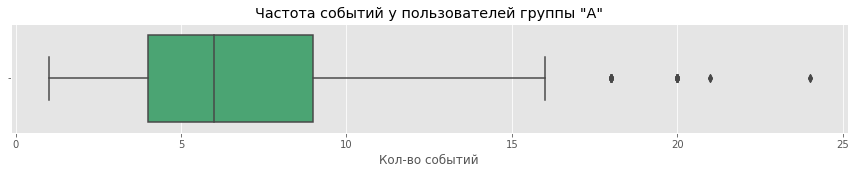

In [45]:
plt.figure(figsize=(15,2))
plt.style.use('ggplot')
sns.boxplot(x=temp_007['count'], color='MediumSeaGreen');
plt.title('Частота событий у пользователей группы "А"')
plt.xlabel('Кол-во событий');

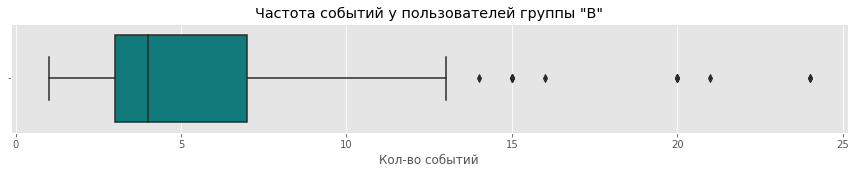

In [46]:
plt.figure(figsize=(15,2))
plt.style.use('ggplot')
sns.boxplot(x=temp_008['count'], color='DarkCyan');
plt.title('Частота событий у пользователей группы "В"')
plt.xlabel('Кол-во событий');

**Видим, что пользователи группы "А" в среднем совершают больше событий (медиана на уровне 6 + больший разброс), чем пользователи группы "В" (медиана на уровне 4).**

### Количество событий по дням

>- сделаем временный датасет с группировкой по датам события
>- построим график в разрезе групп

In [47]:
temp_08 = group_me(uni, level=['dt', 'group'], agglevel='user_id', aggfunc='count')
temp_08['dt'] = temp_08['dt'].dt.day
temp_08 = temp_08.sort_values(by='dt')
temp_08_a = temp_08.query('group == "A"').reset_index(drop=True)
temp_08_b = temp_08.query('group == "B"').reset_index(drop=True)
#temp_08_a.head()

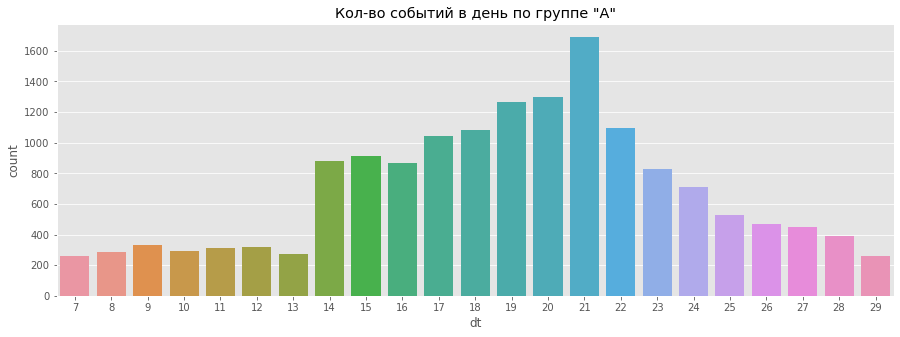

In [48]:
plt.figure(figsize=(15,5))
sns.barplot(data=temp_08_a, x='dt', y='count')
plt.title('Кол-во событий в день по группе "А"');

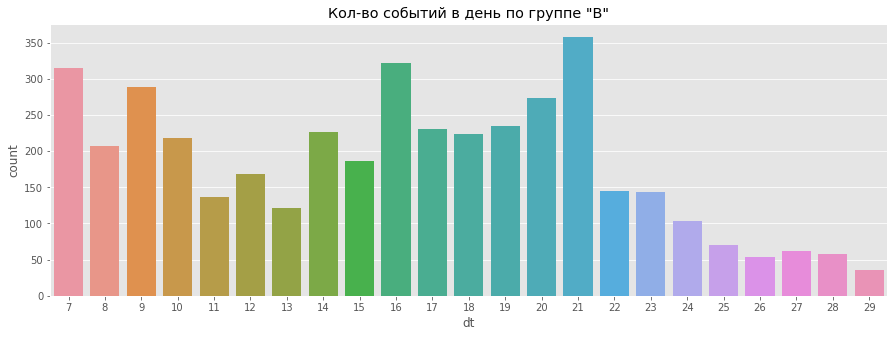

In [49]:
plt.figure(figsize=(15,5))
sns.barplot(data=temp_08_b, x='dt', y='count')
plt.title('Кол-во событий в день по группе "B"');

In [50]:
# fig = (px.bar(temp_08, x='dt', y='count', color='group', 
#               title='Распределение событий по дням в разрезе групп'))
# fig.update_xaxes(title_text='Дата')
# fig.update_yaxes(title_text='Количество событий')
# fig.show() 

**Видим уже знакомый пик на 21 декабря. Также стабильно пользователи группы "А" совершают больше событий, нежели пользователи группы "В". Интересно, что в начале периода группа "В" была +- наравне (где-то даже лидировала).**

### Количество регистраций по дням

>- проанализируем регистрации в разрезе групп, также создав датасет
>- и построим визуализации

In [51]:
temp_09 = group_me(uni, level=['first_dt', 'group'], agglevel='user_id', aggfunc='nunique')

In [52]:
temp_09['first_dt'] = temp_09['first_dt'].dt.day
temp_09 = temp_09.sort_values(by='first_dt')
temp_09_a = temp_09.query('group == "A"').reset_index(drop=True)
temp_09_b = temp_09.query('group == "B"').reset_index(drop=True)

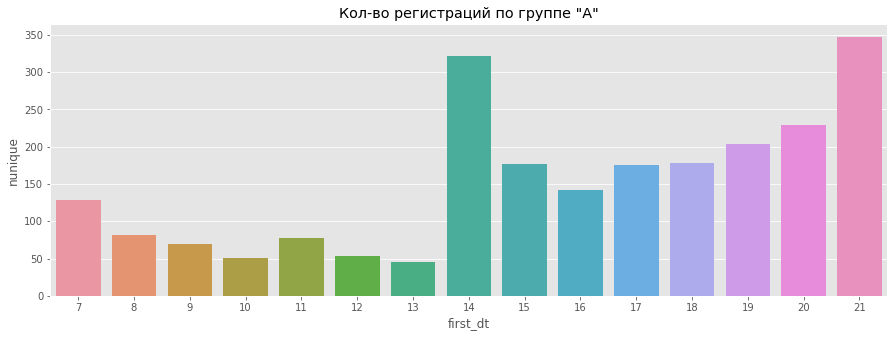

In [53]:
plt.figure(figsize=(15,5))
sns.barplot(data=temp_09_a, x='first_dt', y='nunique')
plt.title('Кол-во регистраций по группе "А"');

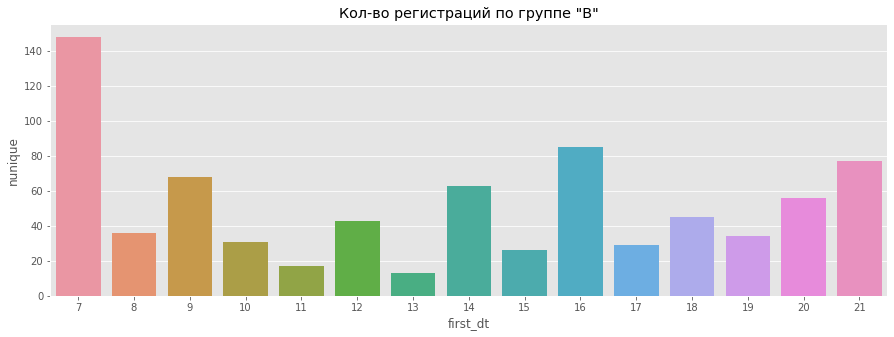

In [54]:
plt.figure(figsize=(15,5))
sns.barplot(data=temp_09_b, x='first_dt', y='nunique')
plt.title('Кол-во регистраций по группе "B"');

In [55]:
# fig = (px.bar(temp_09, x='first_dt', y='nunique', color='group', 
#               title='Распределение регистраций уникальных пользователей'))
# fig.update_xaxes(title_text='Дата')
# fig.update_yaxes(title_text='Количество пользователей')
# fig.show() 

**Есть 3 пика регистраций - 7, 14 и 21 декабря. Возможно, специфика приложения предполагает, что по понедельникам там регистрируются чаще (все 3 пика - это понедельники). Группа "А" по кол-ву лидирует и здесь.**

### Воронки

>- создадим функцию для создания датафрейма с воронками в разрезе групп
>- создадим фреймы с воронками
>- визуализируем воронки, сделаем выводы

##### функция воронки по группе

In [56]:
def funnel_me(data):
    
    basa = list(data['user_id'].unique())
    log = list(data.query('event_name == "login"')['user_id'].unique())
    prod = list(data.query('event_name == "product_page"')['user_id'].unique())
    cart = list(data.query('event_name == "product_cart"')['user_id'].unique())
    purch = list(data.query('event_name == "purchase"')['user_id'].unique())
    
    df = pd.DataFrame({'level': ['basa', 'login', 'product_page', 'product_cart', 'purchase'],
                      'users': [len(basa), len(log), len(prod), len(cart), len(purch)]})
    
    return df

In [57]:
a_uni = uni.query('group == "A"')
a_funnel = funnel_me(a_uni)
a_all = a_funnel.iloc[0]['users']
a_funnel['share'] = round(a_funnel['users'] / a_all,2)

b_uni = uni.query('group == "B"')
b_funnel = funnel_me(b_uni)
b_all = b_funnel.iloc[0]['users']
b_funnel['share'] = round(b_funnel['users'] / b_all,2)
#print(a_all, b_all, b_funnel)

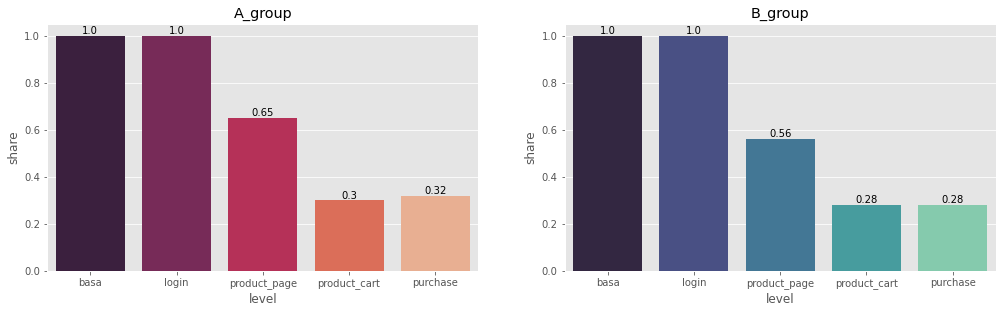

In [58]:
plt.figure(figsize=(17,10))
plt.style.use('ggplot')

ax_1 = plt.subplot(2,2,1)
sns.barplot(data=a_funnel, x='level', y='share', palette='rocket')
for index, value in enumerate(a_funnel['share']):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.title("A_group")

ax_2 = plt.subplot(2,2,2)
sns.barplot(data=b_funnel, x='level', y='share', palette='mako')
for index, value in enumerate(b_funnel['share']):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.title("B_group");

In [59]:
# fig = go.Figure(go.Funnel(
#     y = a_funnel['level'],
#     x = a_funnel['users'],
#     textposition = "inside",
#     textinfo = "value+percent initial"))
                                
# fig.update_layout(
#     title="Воронка группы А",
#     yaxis_title="Этап воронки")

# fig.show()

In [60]:
# fig = go.Figure(go.Funnel(
#     y = b_funnel['level'],
#     x = b_funnel['users'],
#     textposition = "inside",
#     textinfo = "value+percent initial"))
                                
# fig.update_layout(
#     title="Воронка группы B",
#     yaxis_title="Этап воронки")

# fig.show()

<b>Предварительно воронка группы "А" показала себя лучше на всех этапах - конверсия незначительно выше. До того, как переходить к А/В тестированию, сформулируем промежуточные выводы о данных:
    
>- в первоначальном датасете от заказчика собраны данные не по заявленному периоду (не хватает данных в период 31/12/20-04/01/21). Также в последние дни декабря набор событий минимален. Это может оказать влияние на результаты теста, тк события части пользователей отсуствуют, а те, кто зарегистрировался после 17 декабря - и вовсе по логам не успел "прожить" в приложении положенные 14 дней
>- выборка также меньше заявленной: около 3000 оказались релеватной выборкой для теста. Результат теста может оказаться нерелеватным для представления результатов по всему ЕС (заказчик изначально хотел сделать вывод по региону на основе 15% от всех новых пользователей, что составило цифру около 6000 человек)
>- заказчик не указал, может ли клиент напрямую переходить на любой из этапов воронки, поэтому в данном случае будем проводить z-тест с базой в виде кол-ва пользователей в групппах (гибкая воронка)

## Анализ результатов А/В-теста

>- создадим функцию для проведения z-теста
>- сформулируем нулевую и альтернативную гипотезы на каждом этапе воронки
>- проведем z-тест и сделаем выводы

In [61]:
def z_test(group_1, group_2, level, alpha=0.05): # group_n - выборки, level - уровень воронки, alpha - уровень стат знач-ти
    
    def get_array(group_1, group_2, level=level): #функция для формирования списков по заданному уровню (офферы, корзина, оплата)              
        base = np.array([group_1.loc[0, 'users'], group_2.loc[0, 'users']]) # кол-во юзеров в группах 
        converse = np.array([group_1.loc[level, 'users'], group_2.loc[level, 'users']]) # рассматриваемый уровень воронки
        return base, converse 
   
    base, converse = get_array(group_1, group_2, level)
    
    p_1 = converse[0] / base[0]
    p_2 = converse[1] / base[1]
    
    print(converse[0], converse[1], base[0],base[1])

    p_combo = (converse[0] + converse[1]) / (base[0] + base[1])
    diff = p_1 - p_2

    z_value = diff / mth.sqrt(p_combo * (1 - p_combo) * (1/base[0] + 1/base[1]))
    distr = st.norm(0,1)

    p_value = round((1 - distr.cdf(abs(z_value))) * 2,5)
    
    if p_value < alpha:
        text_me = 'Отвергаем нулевую гипотезу: между долями есть значимая разница'
    else:
        text_me = 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'   
    
    return p_value, text_me

<div class="alert alert-info"><b>
Сформулируем гипотезы (конверсия в login):
    <br>H0 (нулевая гипотеза) - между долями нет статистически значимых различий
    <br>H1 (альтеративная гипотеза) - между долями есть статистически значимые различия

In [62]:
p_value, text_me = z_test(a_funnel, b_funnel, 1)
display(p_value, text_me)

2279 770 2279 771


0.08551

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

<b> Формально оставляем этот этап - здесь нет стат.значимой разницы, тк цифры +- одинаковы в разрезе групп (почти все перешли на этап login)

<div class="alert alert-info"><b>
Сформулируем гипотезы (конверсия в product_page):
    <br>H0 (нулевая гипотеза) - между долями нет статистически значимых различий
    <br>H1 (альтеративная гипотеза) - между долями есть статистически значимые различия

In [63]:
p_value, text_me = z_test(a_funnel, b_funnel, 2)
display(p_value, text_me)

1476 429 2279 771


1e-05

'Отвергаем нулевую гипотезу: между долями есть значимая разница'

**На этапе перехода на продуктовую страницу есть разница в группах. Конверсия группы "А" фактически выше конверсии группы "В" (видели это на этапе воронок).**

<div class="alert alert-info"><b>
Сформулируем гипотезы (конверсия в product_cart):
    <br>H0 (нулевая гипотеза) - между долями нет статистически значимых различий
    <br>H1 (альтеративная гипотеза) - между долями есть статистически значимые различия**

In [64]:
p_value, text_me = z_test(a_funnel, b_funnel, 3)
display(p_value, text_me)

686 214 2279 771


0.21721

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

<b>На этом этапе z-тест не показал стат.значимых различий между группами.

<div class="alert alert-info"><b>
Сформулируем гипотезы (конверсия в purchase):
    <br>H0 (нулевая гипотеза) - между долями нет статистически значимых различий
    <br>H1 (альтеративная гипотеза) - между долями есть статистически значимые различия**

In [65]:
p_value, text_me = z_test(a_funnel, b_funnel, 4)
display(p_value, text_me)

734 219 2279 771


0.04894

'Отвергаем нулевую гипотезу: между долями есть значимая разница'

<b>На конверсии в покупку найдены статистически значимые различия между группами (конверсия больше в группе "А")

## Выводы

**Итого что сделали:**
- предобработали данные, посмотрели на предмет пропусков, дубликатов, форматирования полей
- проверили и отфильтровали данные заказчика согласно техническому заданию (период и регион анализа)
- проверили группы и отобрали выборку для А/В тестирования
- построили воронки, посмотрев конверсии по всем этапам воронки в разрезе уникального пользователя / группы пользователя
- проанализировали результаты в разрезе групп А/В тестирования
<br>

**Выводы по результатам А/В теста:**
- Проведя z-тест на всех уровнях воронки, статистически значимые различия мы увидели на этапах перехода в продуктовую корзину / в покупку.
- На этапах перехода в продукт.карточку / на этап с логином статистически значимых отличий между выборками не найдено.
- По расчету конверсий в воронках НЕ увидели рост на 10% на каждом этапе по группе "В". В целом, по конверсиям на всех этапах группа "А" показала себя лучше группы "В".

<br>**По увиденному можно сказать, что группа "А" по результатам исследования оказалась лучше группы "В". Вместе с тем см. следующий блок.**

**Комментарий по поводу данных от заказчика:**
- данные по событиями собраны не по заявленному периоду (не хватает данных в период 31/12/20-04/01/21). Также в последние дни декабря набор событий минимален
- из-за пункта выше не все пользователи по логам успели провести в приложении 14 дней - некоторые события не попали в анализ, хотя должны были (и возможно это бы повлияло на итоговые рез-ты теста)
- часть пользователей в сете с участниками А/В тестирования не совершила никаких действий в тестируемый период
- одновременно проводилось 2 А/В тестирования, что вызвало пересечение групп и существенно сократило выборку (убрали 11 тысяч юзеров из 16 тысяч)

**Анализ А/В тестирования сделан, вместе с тем нельзя до конца доверять выявленным результатам - тк нарушен ряд правил сбора данных для теста.**
    

<br>Из рекомендаций заказчику: 
- подключать аналитика на этапе продумывания дизайна эксперимента, чтобы избежать наложения выборок / составлять исполнимые ожидания от эксперимента
- по возможности исключать единовременное проведение 2 А/В тестирований (как вариант - разводить по регионам/датам)
- для проверки гипотезы, по которой проводили А/В тест (новая платежная воронка) рекомендовано повторить тестирование - с иной организацией сбора данных согласно комментариям выше